In [1]:
%%capture
!pip install xbatcher tensorboard imbalanced-learn

In [2]:
import os
if 'notebooks' in os.getcwd():
    os.chdir("..")

import util
import torch
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

# If we have gpu available, use it
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()
torch.set_default_device(device)

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cpu



Prepare data

In [3]:
ds = xr.open_dataset("data_working/westmort.nc")\
    .squeeze(drop=True)\
    .drop_vars("spatial_ref")

In [4]:
# Use EWMA to smooth mortality observations
ds["mort_ewma"] = xr.apply_ufunc(
    util.manip.numpy_ewma_vectorized,
    ds.mortality,
    input_core_dims=[["time"]],
    output_core_dims=[["time"]],
    vectorize=True,
    kwargs=dict(window=3)
)

In [5]:
# Calculate total basal area based on all the genus rasters
ba_vars = ["abies", "picea", "populus", "tsuga", "pseudotsuga"]
ds["forest_ba"] = ds[ba_vars].to_stacked_array("band", sample_dims=["x", "y", "time"]).sum(dim="band")

In [6]:
ds = ds.to_stacked_array("band", sample_dims=["x", "y", "time"])\
    .transpose("time", "band", ...)
ds

<xarray.DataArray 'abies' (time: 27, band: 18, y: 652, x: 590)> Size: 748MB
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ...,  0.,  0.,  0.],
         [nan, nan, nan, ...,  0.,  0.,  0.],
         [nan, nan, nan, ...,  0.,  0.,  0.]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]]]], dtype=float32)
Coordinates:
  * x         (x) float64 5kB -1.389e+07 -1.389e+07 ... -1.154e+07 -1.154e+07
  * y         (y) float64 5kB 6.278e+06 6.274e+06 ... 3.678e+06 3.674e+06
  * time      (time) int64 216B 1997 1998 1999 2000 2001 ... 2020 2021 2022 2023
  * band      (band) object 144B MultiIndex
  * variable  (band) <U11 792B 'abies' 'picea' ... 'mort_ewma' 'forest_ba'

Make sure windowing works right

In [7]:
window = dict(x=[8, False], y=[8, False], time=[5, False])
mort_arr = ds.sel(band="mort_ewma", drop=True)
mort_ds = util.datasets.WindowXarrayDataset(ds, window, mask=mort_arr)

print(len(mort_ds))

89226


In [8]:
eg_window = mort_ds[10]
window_x = eg_window.isel(time=slice(None, -1))
window_y = eg_window.isel(time=-1).sel(band="mort_ewma")

In [9]:
assert not np.any(np.isnan(window_y.values))

Set up model definition

In [10]:
ds.band

<xarray.DataArray 'band' (band: 18)> Size: 144B
array([('abies',), ('picea',), ('populus',), ('pseudotsuga',), ('tsuga',),
       ('vod',), ('elev',), ('slope',), ('northness',), ('eastness',),
       ('fire',), ('mortality',), ('prcp',), ('vp',), ('tmin',),
       ('treecover',), ('mort_ewma',), ('forest_ba',)], dtype=object)
Coordinates:
  * band      (band) object 144B MultiIndex
  * variable  (band) <U11 792B 'abies' 'picea' ... 'mort_ewma' 'forest_ba'

In [11]:
from util.convlstm import DamageConvLSTM

input_bands = ["fire", "mort_ewma", "prcp", "elev", "treecover", "forest_ba"]
input_inds = np.where(np.isin(ds.coords.get("variable").values, input_bands))[0]
input_channel = len(input_bands)
hidden_dim = 8
num_layers = 2
kernel = (3, 3)

m = DamageConvLSTM(input_channel, hidden_dim, kernel, num_layers, batch_first=True) 

Verify that the shapes work out.

In [12]:
fake_input = torch.tensor(window_x.isel(band=input_inds).values).unsqueeze(0).to(torch.float32)
fake_output = m(fake_input)
assert fake_output.shape == window_y.shape

Data pipeline

In [13]:
# Prepare data laoders. Since we are using a 5-year lookback here, each dataset
# has to be temporally disjoint so we don't leak data. Since 2020 had very few
# surveys we have to ignore it.
years = ds.time.values

train_years = years[16:]
valid_years = years[:8]
test_years = years[8:16]

print("Training years:", train_years)
print("Validation years:", valid_years)
print("Testing years:", test_years)

Training years: [2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023]
Validation years: [1997 1998 1999 2000 2001 2002 2003 2004]
Testing years: [2005 2006 2007 2008 2009 2010 2011 2012]


In [14]:
valid_wds = util.datasets.WindowXarrayDataset(
    ds.sel(time=valid_years), window, 
    mask=mort_arr.sel(time=valid_years), 
)
test_wds  = util.datasets.WindowXarrayDataset(
    ds.sel(time=test_years), window, 
    mask=mort_arr.sel(time= test_years), 
)

print("Count of examples")
print("Validation:", len(valid_wds))
print("Testing:", len(test_wds))

Count of examples
Validation: 8361
Testing: 22516


In [15]:
from torch.utils.data import DataLoader

target = "mort_ewma"
target_ind = np.where(ds.coords.get("variable").values == target)[0][0]

dtype = torch.float32
# cutoff = 1

def collator(patch_list):
    X = torch.stack([
        torch.tensor(
            np.squeeze(patch.values[:-1, input_inds, :, :]),
            dtype=dtype
        )
        for patch in patch_list
    ])

    # Replace nan cells with the channel mean from this batch
    ch_mean = torch.nanmean(X, dim=0)
    X = torch.nan_to_num(X)
    X += ch_mean * torch.isnan(X)
    
    y = torch.stack([
        torch.tensor(patch.values[-1, target_ind, :, :], dtype=dtype)
        for patch in patch_list
    ]).squeeze(dim=2)/100

    return X, y

batch_size = 32

# Setting the RNG to host device is necessary if we want to run on GPU
valid_loader = DataLoader(valid_wds, batch_size, shuffle=True, collate_fn=collator, generator=torch.Generator(device=device))
test_loader  = DataLoader(test_wds , batch_size, shuffle=True, collate_fn=collator, generator=torch.Generator(device=device))

In [16]:
# Again make sure the sizes work out
X, y = tuple(next(iter(valid_loader)))
print(X.shape)
out = m(X)
print(out.shape)
assert out.shape == y.shape

torch.Size([32, 4, 6, 8, 8])
torch.Size([32, 8, 8])


Resampling the training dataset. We want to reduce the proportion of examples with near-zero mortality in the training dataset. But undersampling the majority classes will result in fewer overall samples. Let's calculate the effect.

In [17]:
reload(util.datasets)

<module 'util.datasets' from '/home/jovyan/ForestLST/util/datasets.py'>

In [18]:
cutoffs = np.arange(0.5, 10, step=0.5)
ns = np.zeros(cutoffs.shape)

train_ds = ds.sel(time=train_years)

window_mean = train_ds.isel(band=target_ind).rolling(x=8, y=8, time=5).mean()

for i, c in enumerate(cutoffs):
    ns[i] = (window_mean > c).sum().values

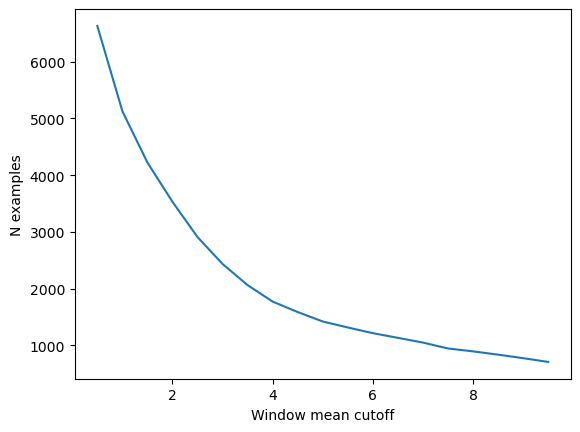

In [19]:
plt.plot(cutoffs, ns)
plt.xlabel("Window mean cutoff")
plt.ylabel("N examples")
plt.show()

In [20]:
reload(util.training)
from util.training import BaseTrainer, ReduceLRMixin, MaskedLossMixin

# Masked loss is very slow for some reason
class Trainer(ReduceLRMixin, BaseTrainer):
    pass

In [21]:
import torchmetrics
from util.convlstm import DamageConvLSTM

folder_name = ""
#ratios = np.pow(10, np.arange(-1, 1, step=0.25))

wds = util.datasets.WindowXarrayDataset(
    train_ds, window, mask=mort_arr.sel(time=train_years)
)
print(f"N: {len(wds)}")

train_loader = DataLoader(
    wds, batch_size, 
    shuffle=True, collate_fn=collator, 
    generator=torch.Generator(device=device)
)

# Model params
input_channel = len(input_bands)
hidden_dim = 8
num_layers = 2
kernel = (3, 3)
m = DamageConvLSTM(input_channel, hidden_dim, kernel, num_layers, batch_first=True) 

# Build trainer
loss = torch.nn.MSELoss()
opt  = torch.optim.Adam(m.parameters(), lr=0.005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=3, factor=0.2)
metrics = util.training.get_regr_metrics()

model_name = f"convlstm_small__8_8_5__ewma__6band"

trainer = Trainer(
    m, opt, scheduler, loss, train_loader, valid_loader,
    metrics=metrics, 
    n_epochs=30,
    tensorboard_log=os.path.join("logs", folder_name, model_name, "history"),
    model_log=os.path.join("logs", folder_name, model_name, "model.pth"),
    verbose=True
)

trainer.train()

N: 17426


/home/jovyan/ForestLST/util/training.py:131: UserWarning: Log already exists at logs/convlstm_small__8_8_5__ewma__6band/history
  warnings.warn(f"Log already exists at {tensorboard_log}")
/home/jovyan/ForestLST/util/training.py:140: UserWarning: Saved model already exists at logs/convlstm_small__8_8_5__ewma__6band/model.pth. This will be overwritten on first epoch!
  warnings.warn(


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Training loss:   0%|          | 0/545 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch 1 of 30
                                      Key           Value
0                            LearningRate           0.005
1                              Loss/train         0.00811
2                              Loss/valid  tensor(0.0028)
3               MeanAbsoluteError()/train     0.049316954
4               MeanAbsoluteError()/valid     0.028445076
5  NormalizedRootMeanSquaredError()/train        4.293578
6  NormalizedRootMeanSquaredError()/valid       3.5172904
7                         R2Score()/train      -1.0773087
8                         R2Score()/valid    -0.014153242



Training loss:   0%|          | 0/545 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch 2 of 30
                                      Key           Value
0                            LearningRate           0.005
1                              Loss/train        0.002861
2                              Loss/valid  tensor(0.0017)
3               MeanAbsoluteError()/train     0.028655313
4               MeanAbsoluteError()/valid     0.018924374
5  NormalizedRootMeanSquaredError()/train        2.550821
6  NormalizedRootMeanSquaredError()/valid        2.719775
7                         R2Score()/train      0.26680124
8                         R2Score()/valid       0.3936084



Training loss:   0%|          | 0/545 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch 3 of 30
                                      Key           Value
0                            LearningRate           0.005
1                              Loss/train        0.001304
2                              Loss/valid  tensor(0.0016)
3               MeanAbsoluteError()/train     0.018072221
4               MeanAbsoluteError()/valid     0.014682473
5  NormalizedRootMeanSquaredError()/train       1.7212809
6  NormalizedRootMeanSquaredError()/valid       2.6298974
7                         R2Score()/train       0.6661397
8                         R2Score()/valid      0.43302327



Training loss:   0%|          | 0/545 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch 4 of 30
                                      Key           Value
0                            LearningRate           0.005
1                              Loss/train        0.001125
2                              Loss/valid  tensor(0.0014)
3               MeanAbsoluteError()/train     0.015660224
4               MeanAbsoluteError()/valid     0.013390874
5  NormalizedRootMeanSquaredError()/train       1.5993668
6  NormalizedRootMeanSquaredError()/valid       2.5322602
7                         R2Score()/train      0.71175784
8                         R2Score()/valid       0.4743411



Training loss:   0%|          | 0/545 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch 5 of 30
                                      Key           Value
0                            LearningRate           0.005
1                              Loss/train        0.001014
2                              Loss/valid  tensor(0.0015)
3               MeanAbsoluteError()/train     0.014455252
4               MeanAbsoluteError()/valid    0.0127381105
5  NormalizedRootMeanSquaredError()/train       1.5182688
6  NormalizedRootMeanSquaredError()/valid       2.5544295
7                         R2Score()/train       0.7402479
8                         R2Score()/valid      0.46509707



Training loss:   0%|          | 0/545 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch 6 of 30
                                      Key           Value
0                            LearningRate           0.005
1                              Loss/train        0.000952
2                              Loss/valid  tensor(0.0015)
3               MeanAbsoluteError()/train    0.0137379235
4               MeanAbsoluteError()/valid     0.012749577
5  NormalizedRootMeanSquaredError()/train       1.4712613
6  NormalizedRootMeanSquaredError()/valid       2.5501325
7                         R2Score()/train       0.7560832
8                         R2Score()/valid      0.46689487



Training loss:   0%|          | 0/545 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch 7 of 30
                                      Key           Value
0                            LearningRate           0.005
1                              Loss/train         0.00091
2                              Loss/valid  tensor(0.0014)
3               MeanAbsoluteError()/train     0.013197392
4               MeanAbsoluteError()/valid     0.012033198
5  NormalizedRootMeanSquaredError()/train       1.4382145
6  NormalizedRootMeanSquaredError()/valid       2.5246694
7                         R2Score()/train      0.76691777
8                         R2Score()/valid      0.47748804



Training loss:   0%|          | 0/545 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch 8 of 30
                                      Key           Value
0                            LearningRate           0.005
1                              Loss/train        0.000851
2                              Loss/valid  tensor(0.0014)
3               MeanAbsoluteError()/train     0.012718205
4               MeanAbsoluteError()/valid     0.012279479
5  NormalizedRootMeanSquaredError()/train       1.3909203
6  NormalizedRootMeanSquaredError()/valid       2.5297213
7                         R2Score()/train       0.7819946
8                         R2Score()/valid      0.47539443



Training loss:   0%|          | 0/545 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch 9 of 30
                                      Key           Value
0                            LearningRate           0.005
1                              Loss/train        0.000817
2                              Loss/valid  tensor(0.0014)
3               MeanAbsoluteError()/train     0.012337678
4               MeanAbsoluteError()/valid       0.0116688
5  NormalizedRootMeanSquaredError()/train       1.3630676
6  NormalizedRootMeanSquaredError()/valid        2.535703
7                         R2Score()/train       0.7906386
8                         R2Score()/valid       0.4729104



Training loss:   0%|          | 0/545 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch 10 of 30
                                      Key           Value
0                            LearningRate           0.005
1                              Loss/train        0.000775
2                              Loss/valid  tensor(0.0015)
3               MeanAbsoluteError()/train     0.011976528
4               MeanAbsoluteError()/valid     0.011579426
5  NormalizedRootMeanSquaredError()/train       1.3267186
6  NormalizedRootMeanSquaredError()/valid       2.5710628
7                         R2Score()/train      0.80165607
8                         R2Score()/valid      0.45810777



Training loss:   0%|          | 0/545 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch 11 of 30
                                      Key           Value
0                            LearningRate           0.001
1                              Loss/train        0.000749
2                              Loss/valid  tensor(0.0015)
3               MeanAbsoluteError()/train     0.011775566
4               MeanAbsoluteError()/valid     0.012313788
5  NormalizedRootMeanSquaredError()/train       1.3050978
6  NormalizedRootMeanSquaredError()/valid       2.5758119
7                         R2Score()/train       0.8080677
8                         R2Score()/valid      0.45610398



Training loss:   0%|          | 0/545 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch 12 of 30
                                      Key           Value
0                            LearningRate           0.001
1                              Loss/train        0.000697
2                              Loss/valid  tensor(0.0015)
3               MeanAbsoluteError()/train     0.011399555
4               MeanAbsoluteError()/valid     0.011645721
5  NormalizedRootMeanSquaredError()/train       1.2583064
6  NormalizedRootMeanSquaredError()/valid       2.6045094
7                         R2Score()/train       0.8215835
8                         R2Score()/valid      0.44391716



Training loss:   0%|          | 0/545 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch 13 of 30
                                      Key           Value
0                            LearningRate           0.001
1                              Loss/train        0.000681
2                              Loss/valid  tensor(0.0015)
3               MeanAbsoluteError()/train     0.011237117
4               MeanAbsoluteError()/valid     0.011594488
5  NormalizedRootMeanSquaredError()/train       1.2440735
6  NormalizedRootMeanSquaredError()/valid        2.579792
7                         R2Score()/train      0.82559717
8                         R2Score()/valid      0.45442182



Training loss:   0%|          | 0/545 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch 14 of 30
                                      Key           Value
0                            LearningRate           0.001
1                              Loss/train        0.000687
2                              Loss/valid  tensor(0.0015)
3               MeanAbsoluteError()/train     0.011276306
4               MeanAbsoluteError()/valid    0.0116537325
5  NormalizedRootMeanSquaredError()/train       1.2496239
6  NormalizedRootMeanSquaredError()/valid       2.5873618
7                         R2Score()/train       0.8240372
8                         R2Score()/valid      0.45121562



Training loss:   0%|          | 0/545 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch 15 of 30
                                      Key           Value
0                            LearningRate          0.0002
1                              Loss/train        0.000679
2                              Loss/valid  tensor(0.0015)
3               MeanAbsoluteError()/train     0.011192279
4               MeanAbsoluteError()/valid     0.011548622
5  NormalizedRootMeanSquaredError()/train       1.2420787
6  NormalizedRootMeanSquaredError()/valid        2.612558
7                         R2Score()/train       0.8261557
8                         R2Score()/valid      0.44047529



Training loss:   0%|          | 0/545 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch 16 of 30
                                      Key           Value
0                            LearningRate          0.0002
1                              Loss/train        0.000661
2                              Loss/valid  tensor(0.0016)
3               MeanAbsoluteError()/train     0.011013197
4               MeanAbsoluteError()/valid     0.011649135
5  NormalizedRootMeanSquaredError()/train       1.2252958
6  NormalizedRootMeanSquaredError()/valid       2.6359153
7                         R2Score()/train        0.830822
8                         R2Score()/valid       0.4304257



Training loss:   0%|          | 0/545 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch 17 of 30
                                      Key           Value
0                            LearningRate          0.0002
1                              Loss/train        0.000658
2                              Loss/valid  tensor(0.0015)
3               MeanAbsoluteError()/train     0.011053425
4               MeanAbsoluteError()/valid     0.011540196
5  NormalizedRootMeanSquaredError()/train       1.2223828
6  NormalizedRootMeanSquaredError()/valid       2.5814543
7                         R2Score()/train       0.8316255
8                         R2Score()/valid       0.4537189



Training loss:   0%|          | 0/545 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch 18 of 30
                                      Key           Value
0                            LearningRate          0.0002
1                              Loss/train        0.000652
2                              Loss/valid  tensor(0.0015)
3               MeanAbsoluteError()/train     0.010999817
4               MeanAbsoluteError()/valid     0.011484055
5  NormalizedRootMeanSquaredError()/train       1.2170821
6  NormalizedRootMeanSquaredError()/valid       2.5827136
7                         R2Score()/train       0.8330828
8                         R2Score()/valid      0.45318604



Training loss:   0%|          | 0/545 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch 19 of 30
                                      Key           Value
0                            LearningRate         0.00004
1                              Loss/train        0.000654
2                              Loss/valid  tensor(0.0015)
3               MeanAbsoluteError()/train     0.010976129
4               MeanAbsoluteError()/valid     0.011484575
5  NormalizedRootMeanSquaredError()/train       1.2185094
6  NormalizedRootMeanSquaredError()/valid        2.627314
7                         R2Score()/train       0.8326908
8                         R2Score()/valid       0.4341371



Training loss:   0%|          | 0/545 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch 20 of 30
                                      Key           Value
0                            LearningRate         0.00004
1                              Loss/train        0.000655
2                              Loss/valid  tensor(0.0015)
3               MeanAbsoluteError()/train     0.010960999
4               MeanAbsoluteError()/valid     0.011599622
5  NormalizedRootMeanSquaredError()/train       1.2202646
6  NormalizedRootMeanSquaredError()/valid        2.595964
7                         R2Score()/train       0.8322085
8                         R2Score()/valid       0.4475605



Training loss:   0%|          | 0/545 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch 21 of 30
                                      Key           Value
0                            LearningRate         0.00004
1                              Loss/train        0.000651
2                              Loss/valid  tensor(0.0015)
3               MeanAbsoluteError()/train     0.010967779
4               MeanAbsoluteError()/valid     0.011543279
5  NormalizedRootMeanSquaredError()/train       1.2155741
6  NormalizedRootMeanSquaredError()/valid        2.605077
7                         R2Score()/train      0.83349574
8                         R2Score()/valid       0.4436748



Training loss:   0%|          | 0/545 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch 22 of 30
                                      Key           Value
0                            LearningRate         0.00004
1                              Loss/train        0.000645
2                              Loss/valid  tensor(0.0015)
3               MeanAbsoluteError()/train     0.010932563
4               MeanAbsoluteError()/valid     0.011545263
5  NormalizedRootMeanSquaredError()/train       1.2104782
6  NormalizedRootMeanSquaredError()/valid       2.6158793
7                         R2Score()/train       0.8348893
8                         R2Score()/valid      0.43905133



Training loss:   0%|          | 0/545 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch 23 of 30
                                      Key           Value
0                            LearningRate        0.000008
1                              Loss/train        0.000649
2                              Loss/valid  tensor(0.0015)
3               MeanAbsoluteError()/train     0.010912262
4               MeanAbsoluteError()/valid     0.011534502
5  NormalizedRootMeanSquaredError()/train       1.2146075
6  NormalizedRootMeanSquaredError()/valid         2.57409
7                         R2Score()/train       0.8337606
8                         R2Score()/valid      0.45683104



Training loss:   0%|          | 0/545 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch 24 of 30
                                      Key           Value
0                            LearningRate        0.000008
1                              Loss/train        0.000649
2                              Loss/valid  tensor(0.0015)
3               MeanAbsoluteError()/train     0.010949243
4               MeanAbsoluteError()/valid     0.011564137
5  NormalizedRootMeanSquaredError()/train       1.2145951
6  NormalizedRootMeanSquaredError()/valid        2.565465
7                         R2Score()/train       0.8337639
8                         R2Score()/valid      0.46046555



Training loss:   0%|          | 0/545 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch 25 of 30
                                      Key           Value
0                            LearningRate        0.000008
1                              Loss/train        0.000645
2                              Loss/valid  tensor(0.0015)
3               MeanAbsoluteError()/train     0.010901575
4               MeanAbsoluteError()/valid     0.011502642
5  NormalizedRootMeanSquaredError()/train       1.2106878
6  NormalizedRootMeanSquaredError()/valid       2.5768538
7                         R2Score()/train      0.83483183
8                         R2Score()/valid      0.45566434



Training loss:   0%|          | 0/545 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch 26 of 30
                                      Key           Value
0                            LearningRate        0.000008
1                              Loss/train        0.000643
2                              Loss/valid  tensor(0.0016)
3               MeanAbsoluteError()/train    0.0108845765
4               MeanAbsoluteError()/valid     0.011588812
5  NormalizedRootMeanSquaredError()/train       1.2083697
6  NormalizedRootMeanSquaredError()/valid       2.6550918
7                         R2Score()/train      0.83546376
8                         R2Score()/valid        0.422108



Training loss:   0%|          | 0/545 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch 27 of 30
                                      Key           Value
0                            LearningRate        0.000002
1                              Loss/train        0.000651
2                              Loss/valid  tensor(0.0015)
3               MeanAbsoluteError()/train     0.010944322
4               MeanAbsoluteError()/valid     0.011628682
5  NormalizedRootMeanSquaredError()/train       1.2159687
6  NormalizedRootMeanSquaredError()/valid       2.5497682
7                         R2Score()/train       0.8333882
8                         R2Score()/valid      0.46704733



Training loss:   0%|          | 0/545 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch 28 of 30
                                      Key           Value
0                            LearningRate        0.000002
1                              Loss/train        0.000652
2                              Loss/valid  tensor(0.0015)
3               MeanAbsoluteError()/train     0.010963697
4               MeanAbsoluteError()/valid     0.011534462
5  NormalizedRootMeanSquaredError()/train       1.2169944
6  NormalizedRootMeanSquaredError()/valid       2.5909648
7                         R2Score()/train      0.83310664
8                         R2Score()/valid      0.44968605



Training loss:   0%|          | 0/545 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch 29 of 30
                                      Key           Value
0                            LearningRate        0.000002
1                              Loss/train        0.000648
2                              Loss/valid  tensor(0.0015)
3               MeanAbsoluteError()/train    0.0109460605
4               MeanAbsoluteError()/valid     0.011542632
5  NormalizedRootMeanSquaredError()/train       1.2135763
6  NormalizedRootMeanSquaredError()/valid       2.6052973
7                         R2Score()/train       0.8340428
8                         R2Score()/valid      0.44358104



Training loss:   0%|          | 0/545 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch 30 of 30
                                      Key           Value
0                            LearningRate        0.000002
1                              Loss/train        0.000649
2                              Loss/valid  tensor(0.0015)
3               MeanAbsoluteError()/train     0.010955661
4               MeanAbsoluteError()/valid     0.011554525
5  NormalizedRootMeanSquaredError()/train       1.2149655
6  NormalizedRootMeanSquaredError()/valid       2.5625083
7                         R2Score()/train       0.8336627
8                         R2Score()/valid      0.46170837



(<Figure size 640x480 with 3 Axes>, <Axes: title={'center': 'LearningRate'}>)

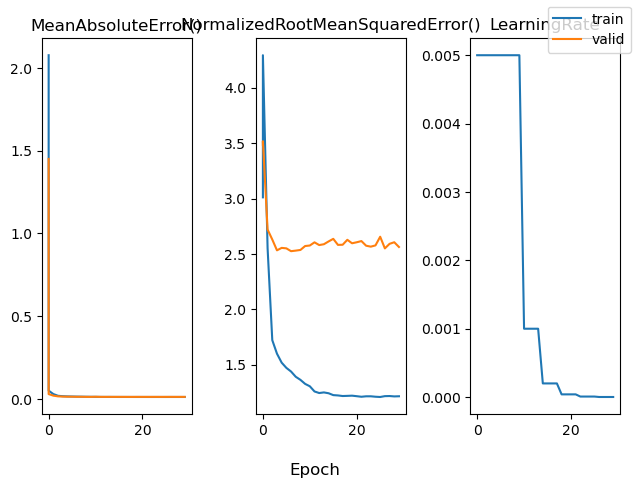

In [23]:
util.plot.plot_all_scalars_in_run("logs/convlstm_small__8_8_5__ewma__6band/history/")

Calculate performance on test set

In [26]:
from tqdm import tqdm
import pandas as pd

metrics = util.training.get_regr_metrics()

m.eval()
with torch.no_grad():
    for (X, y) in tqdm(test_loader, leave=False):
        y_hat = m(X)
        for metric in metrics:
            metric(y_hat.view(-1), y.view(-1))

for metric in metrics:
    print(f"{str(metric)}: {metric.compute():.2f}")

NormalizedRootMeanSquaredError(): 2.34
R2Score(): 0.48
MeanAbsoluteError(): 0.01
